# Fair Classification on Adult Dataset

In [1]:
from pymoo.core.parameters import get_params

In [2]:
import copy
import pytest
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

from fomo import FomoClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.metrics import roc_auc_score, average_precision_score
from pmlb import pmlb   
import fomo.metrics as metrics
from pymoo.algorithms.moo.nsga2 import NSGA2
from pymoo.algorithms.moo.nsga3 import NSGA3
from pymoo.util.ref_dirs import get_reference_directions
dataset = pmlb.fetch_data('adult')
# dataset = dataset.sample(n=2000)
X = dataset.drop('target',axis=1)
y = dataset['target']
Xtrain,Xtest, ytrain,ytest = train_test_split(X,y,
                                            stratify=y, 
                                            random_state=42,
                                            test_size=0.5
                                           )
ss = StandardScaler()
Xtrain = pd.DataFrame(ss.fit_transform(Xtrain), columns=Xtrain.columns, index=ytrain.index)
Xtest = pd.DataFrame(ss.transform(Xtest), columns=Xtest.columns, index=ytest.index)
groups = ['race','sex']

running 8 processes
groups ['race', 'sex']
number of variables: 8
number of objectives: 3
n_gen  |  n_eval  | n_nds  |      eps      |   indicator  
     1 |      100 |     66 |             - |             -
     2 |      200 |    100 |  0.2898170067 |         nadir
     3 |      300 |    100 |  0.0104287879 |         ideal
     4 |      400 |    100 |  0.0049327756 |         ideal
     5 |      500 |    100 |  0.0048109598 |         ideal
     6 |      600 |    100 |  0.0084059093 |             f
     7 |      700 |    100 |  0.0083457693 |         ideal
     8 |      800 |    100 |  0.0234880556 |         ideal
     9 |      900 |    100 |  0.1061019581 |         nadir
    10 |     1000 |    100 |  0.0049066336 |             f


<IPython.core.display.Javascript object>


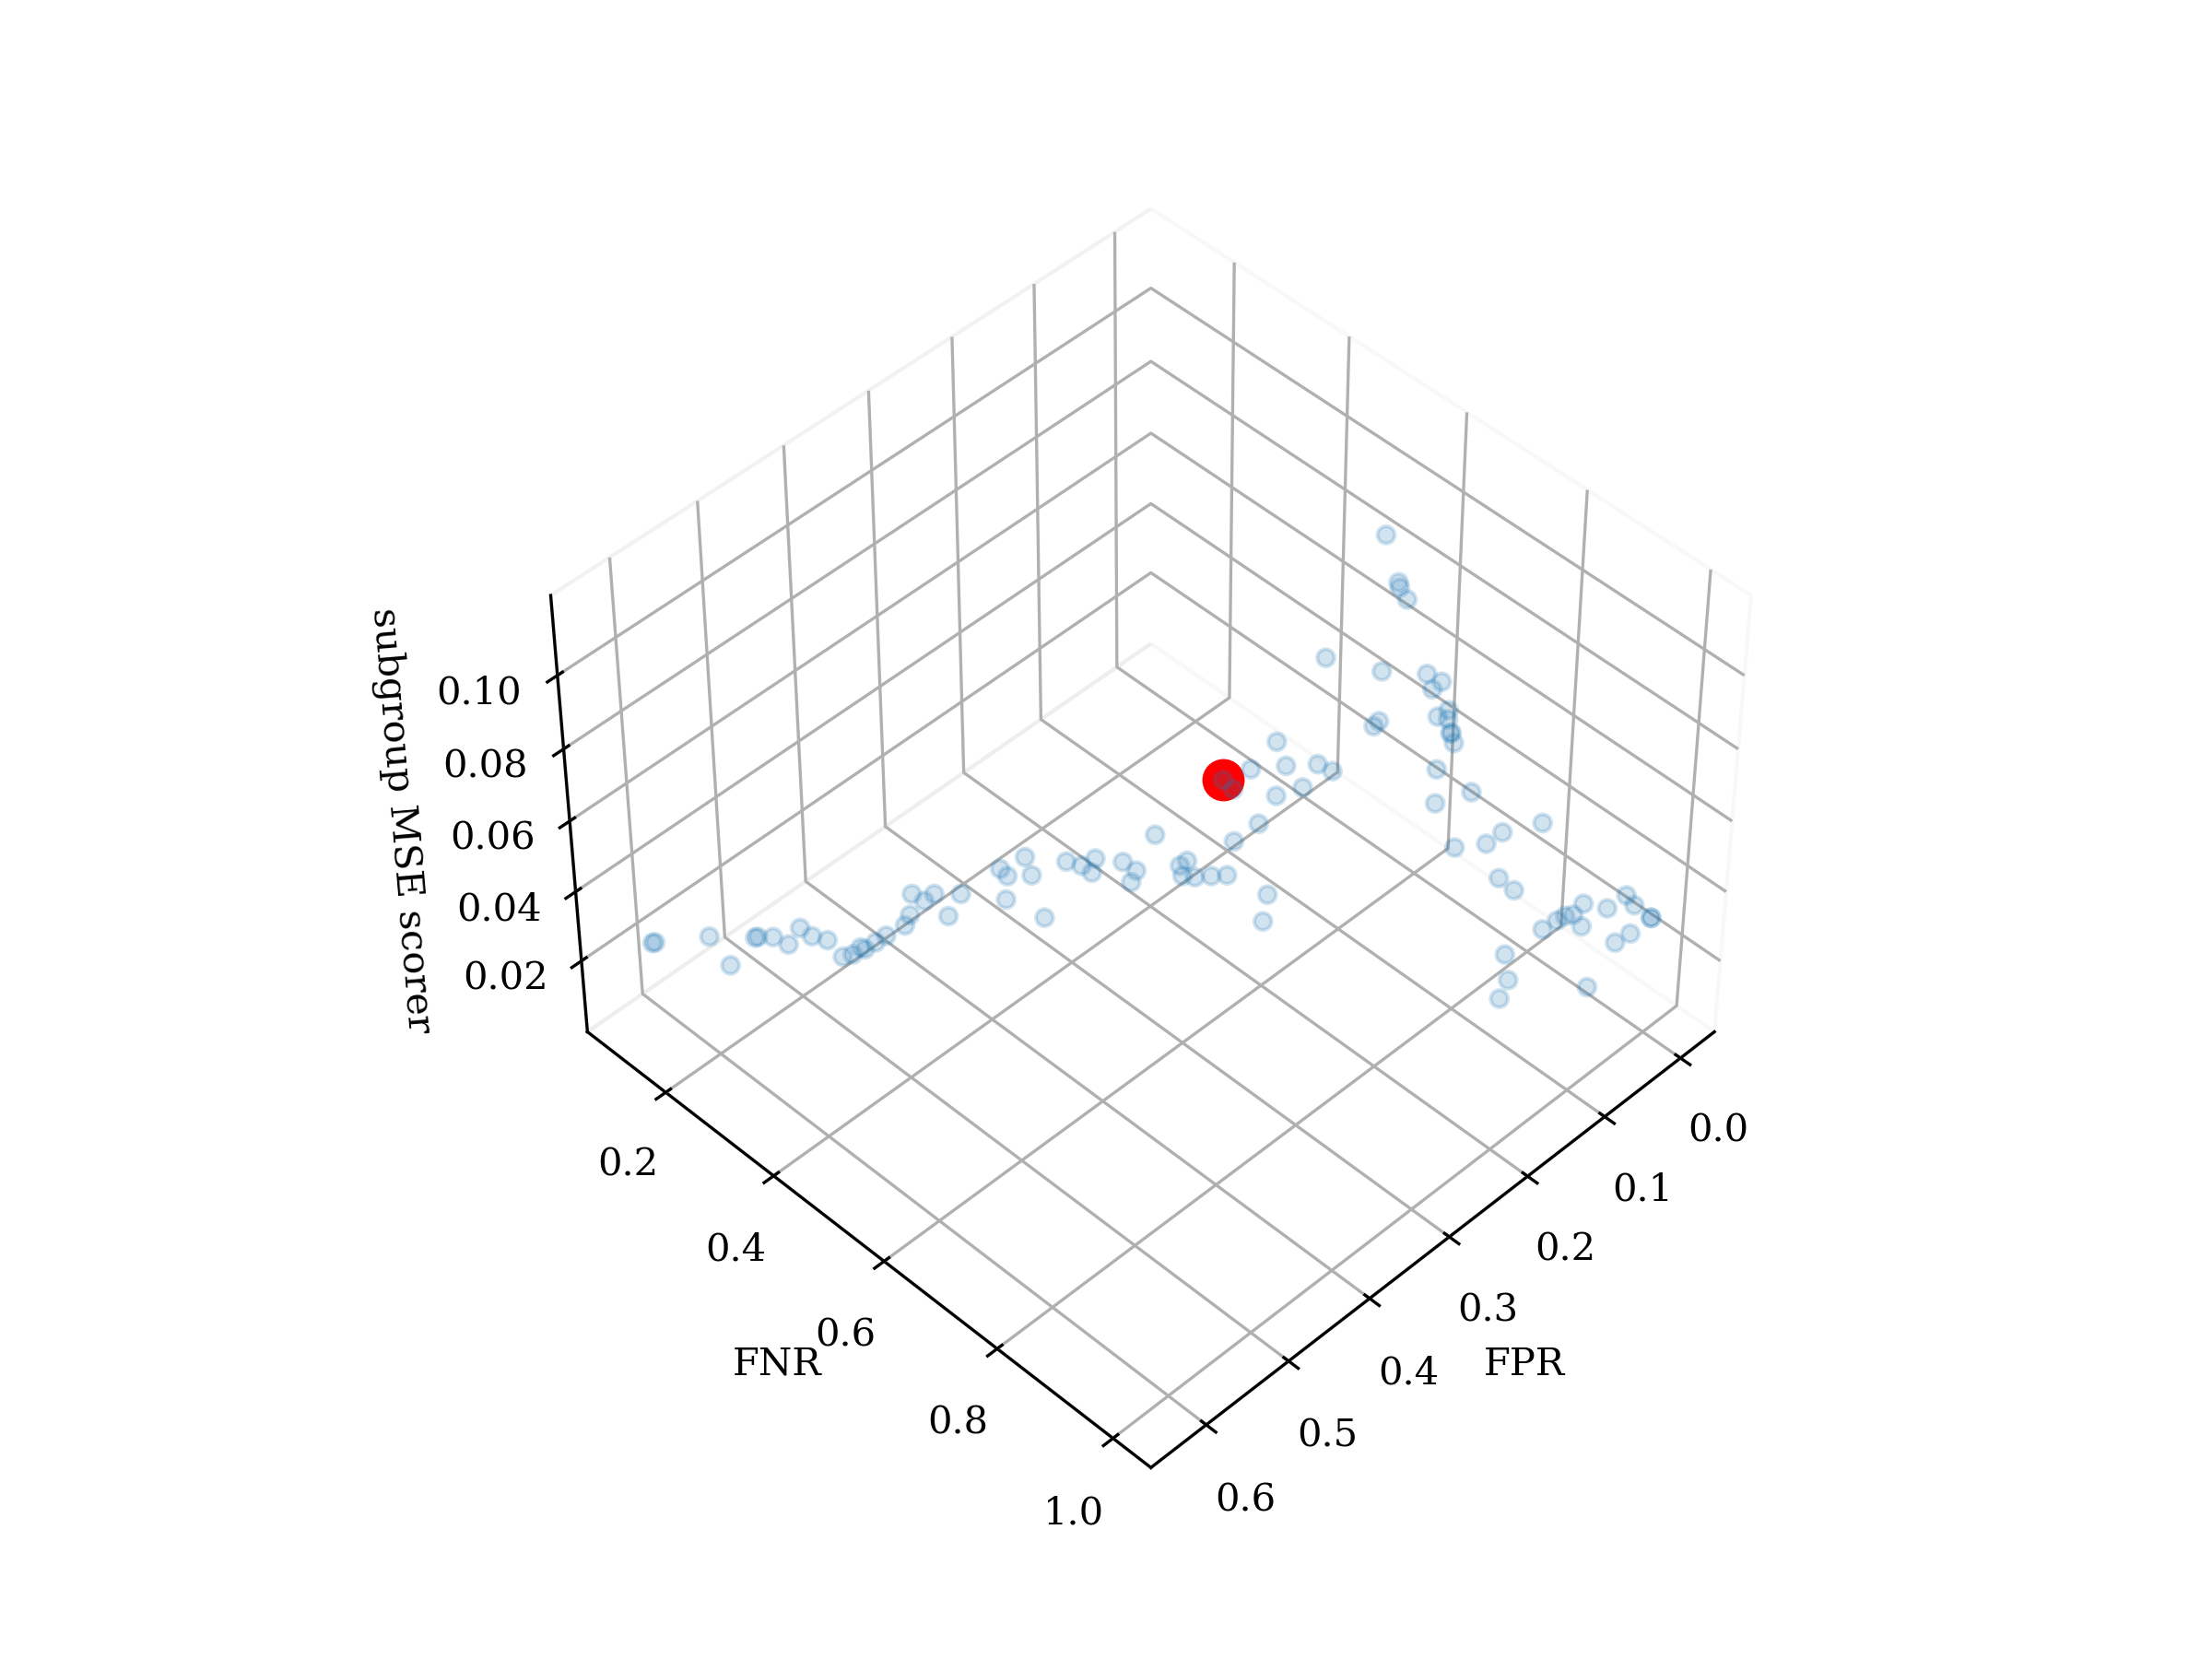

In [13]:
from sklearn.metrics import make_scorer, accuracy_score
from fomo.problem import LinearProblem, InterLinearProblem
from pymoo.operators.sampling.lhs import LHS

est = FomoClassifier(
    estimator = LogisticRegression(),
    accuracy_metrics=[
        make_scorer(metrics.FPR, needs_proba=True),
#         make_scorer(roc_auc_score, needs_proba=True),
        make_scorer(metrics.FNR, needs_proba=True)
    ],
#     accuracy_metrics=[make_scorer(metrics.FPR)],
    fairness_metrics=[metrics.subgroup_MSE_scorer], 
    verbose=True,
    problem_type=LinearProblem,
    algorithm=NSGA2(
#         pop_size=20,
        sampling=LHS()
    )
)

est.fit(
    Xtrain,
    ytrain,
    protected_features=groups, 
    termination=('n_gen',10)
)

est.plot().show()

<IPython.core.display.Javascript object>


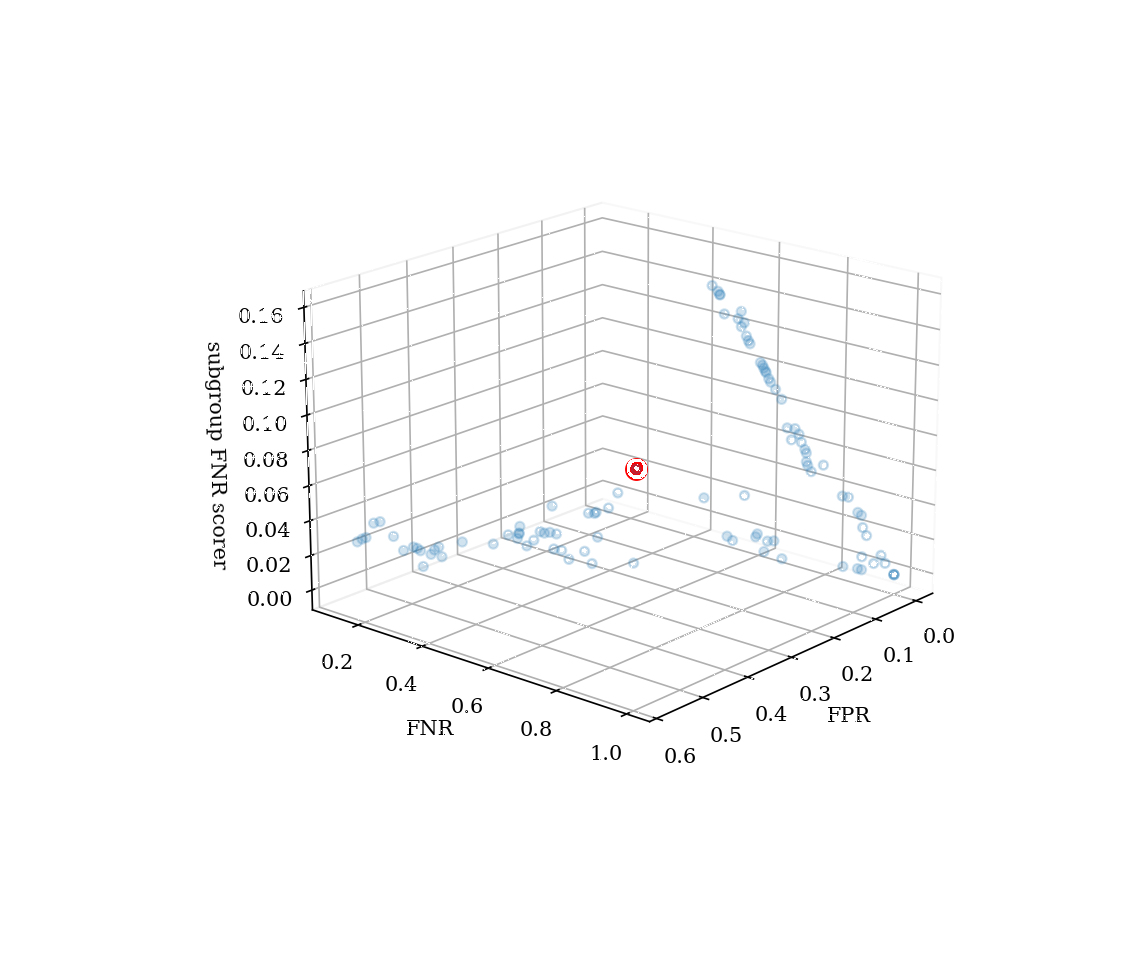

In [12]:
%matplotlib notebook
est.plot().show()

# visualize model set

`est.plot()` will return the Pareto front found during the run, with a red dot indicating the final chosen model. 
By default, Fomo uses the PseudoWeights method from pymoo to choose the final model, which produces a model near the centroid of the front. 

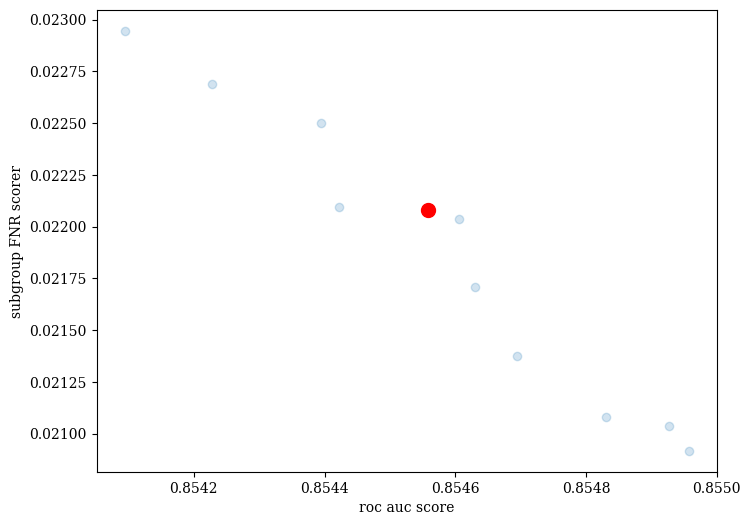

In [6]:
est.plot().show()

## picking with different strategies

We can also pick with other multi-criteria decision making strategies (MDCMs). 
Fomo supports the PseudoWeights, Compromise, and HighTradeoffPoints strategies from [pymoo](https://pymoo.org/mcdm). 

Here's an example of picking with the Compromise strategy.

Text(0.5, 1.0, 'Picking with PseudoWeights')

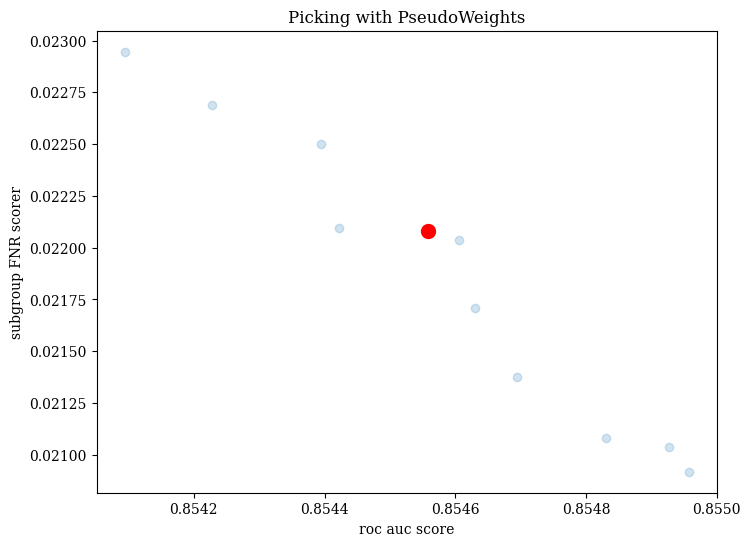

In [7]:
est.best_estimator_ = est.pick_best('PseudoWeights')
plot = est.plot()
plot.show()
plt.title('Picking with PseudoWeights')


Text(0.5, 1.0, 'Picking with Compromise')

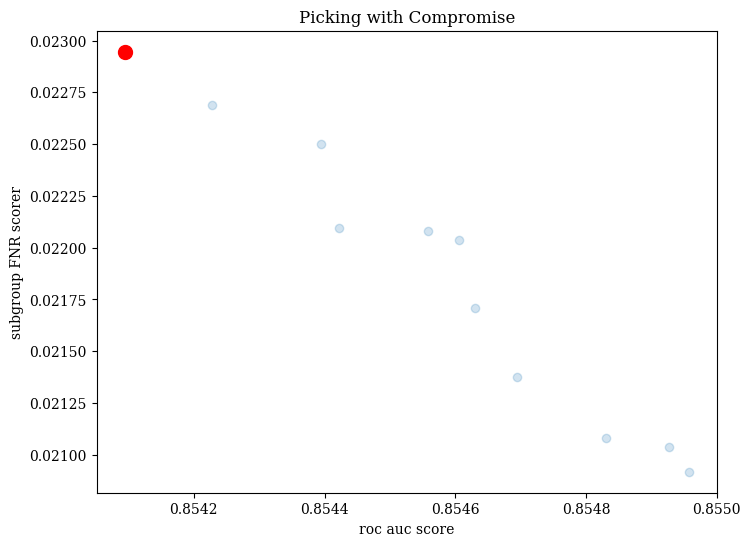

In [8]:
est.best_estimator_ = est.pick_best('Compromise')
plot2 = est.plot()
plot2.show()
plt.title('Picking with Compromise')


Here's an example of picking with the HighTradeoffPoints strategy.

Text(0.5, 1.0, 'Picking with HighTradeoffPoints')

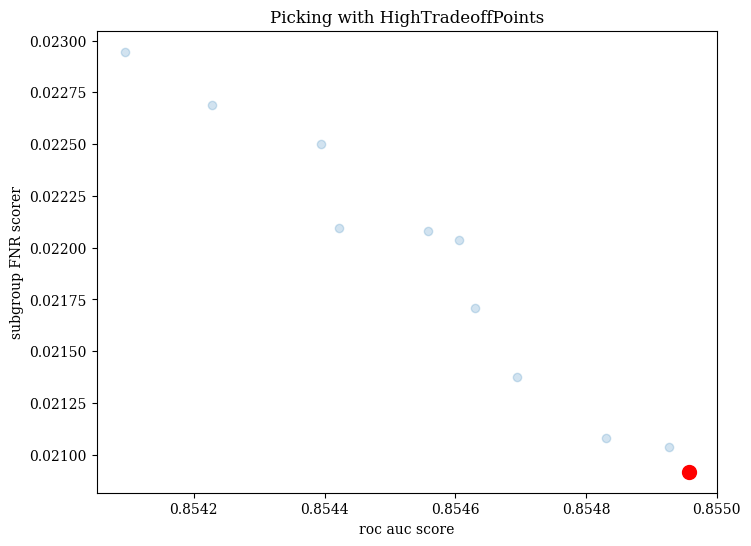

In [9]:
est.best_estimator_ = est.pick_best('HighTradeoffPoints')
plot3 = est.plot()
plot3.show()
plt.title('Picking with HighTradeoffPoints')